Building on our initial exploration, we be more quantitative and try to reproduce something like Fig. 2a in the paper, or at least a portion of it subject to the annealing times we can access. We copy the necessary imports and function definitions:

In [1]:
from dwave.system import EmbeddingComposite, DWaveSampler
import networkx as nx # For drawing graphs
import matplotlib.pyplot as plt
import numpy as np

def anneal_1d_chain(J_val, N, ta, n_reads):
    # Construct dictionaries for qubit biases and couplers:
    h = {} # No biases needed
    J = {} # Coupler dictionary
    for i in range(N):
        key_tuple = ('s{}'.format(i), 's{}'.format((i + 1) % N))
        J[key_tuple] = J_val
    sampler = EmbeddingComposite(DWaveSampler()) # Sampler to use, with auto-embedding
    samples = sampler.sample_ising(h, J, num_reads=n_reads, label='Anneal spin chain from paper', annealing_time=ta) # Do a single anneal

    return samples

def draw_chain(N, spins):
    plt.figure()
    G = nx.Graph()
    G.add_nodes_from(range(N), spin=spins) # Add spins to graph
    for i in range(N):
        G.add_edge(i, (i + 1) % N)

    nx.draw_circular(G, cmap=plt.get_cmap('bwr'), node_color=spins, node_size=100)

Now we vary the annealing time for a fixed chain length and coupling strength:

In [2]:
import csv

ta = np.logspace(0, 3) #np.linspace(0.5, 2000, 10) # Annealing times in us
J = 1
N = 512
n_reads = 100

def calc_kink_density(sample):
    kink_count = len([x for x in range(1, len(sample)) if sample[x] != sample[x - 1]]) 
    kink_density = kink_count/len(sample)
    return kink_density

average_kink_densities = []
for time in ta:
    samples = anneal_1d_chain(J, N, time, n_reads)
    average_kink_density = 0
    n = 0
    for rec in samples.record:
        average_kink_density += rec[2]*calc_kink_density(rec[0])
        n += rec[2]
    average_kink_densities.append(average_kink_density/n)

np.savetxt('ta.csv', ta, delimiter=',')
np.savetxt('average_kink_densities.csv', average_kink_densities, delimiter=',')
params = {'J':J, 'N': N, 'n_reads': n_reads}

w = csv.writer(open("params.csv", "w"))

for key, val in params.items():
    w.writerow([key, val])

Text(0, 0.5, 'Average kink density')

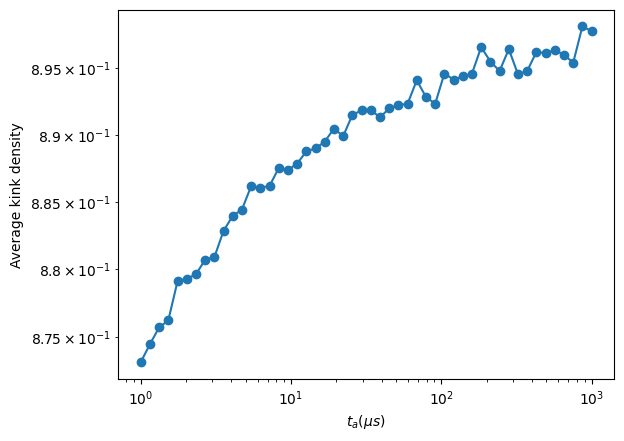

In [3]:
plt.plot(ta, average_kink_densities, '-o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$t_a (\mu s)$')
plt.ylabel('Average kink density')

It is not clear that this is working - comparing to Fig. 2 qualitatively in the appropriate annealing time regime, we do indeed see some plateauing increase in the average kink density, but not the decrease after that we would expect, especially as we anneal over longer times than that plot. We have comparable parameters and the code should be working, so it is not clear why the data give such a mixed picture. Let's investigate more parameter values, firstly the number of reads, but also the coupler strength and chain length. We'll also decrease the number of points to save some computational time.

Annealing time = 0.5 us


Annealing time = 0.6655473668610051 us
Annealing time = 0.8859065950712347 us
Annealing time = 1.1792256032689181 us
Annealing time = 1.5696609903814174 us
Annealing time = 2.0893674780255793 us
Annealing time = 2.781146046809887 us
Annealing time = 3.7019688566204287 us
Annealing time = 4.927671249450343 us
Annealing time = 6.5591972496567115 us
Annealing time = 8.73091291646194 us
Annealing time = 11.621672203687968 us
Annealing time = 15.469546667372526 us
Annealing time = 20.591432102006436 us
Annealing time = 27.409146830775118 us
Annealing time = 36.48417100225808 us
Annealing time = 48.56388788531901 us
Annealing time = 64.64313541321428 us
Annealing time = 86.04613711980834 us
Annealing time = 114.53555997729877 us
Annealing time = 152.45768070968387 us
Annealing time = 202.93561590813195 us
Annealing time = 270.1265296199471 us
Annealing time = 359.56400101571427 us
Annealing time = 478.61374818803296 us
Annealing time = 637.0802397000425 us
Annealing time = 848.0141520230827 

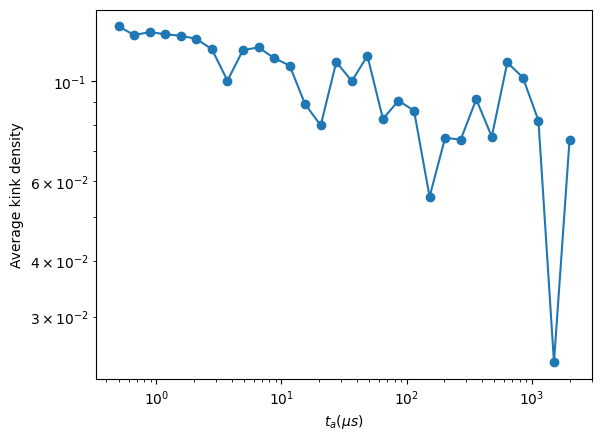

In [3]:
import csv

ta = np.geomspace(0.5, 2000, num=30) # Annealing times in us
J = -1
N = 512
n_reads = 100

def calc_kink_density(sample):
    kink_count = len([x for x in range(1, len(sample)) if sample[x] != sample[x - 1]]) 
    kink_density = kink_count/len(sample)
    return kink_density

average_kink_densities = []
for time in ta:
    print('Annealing time = {} us'.format(time))
    samples = anneal_1d_chain(J, N, time, n_reads)
    average_kink_density = 0
    n = 0
    for rec in samples.record:
        average_kink_density += rec[2]*calc_kink_density(rec[0])
        n += rec[2]
    average_kink_densities.append(average_kink_density/n)

np.savetxt('ta.csv', ta, delimiter=',')
np.savetxt('average_kink_densities.csv', average_kink_densities, delimiter=',')
params = {'J':J, 'N': N, 'n_reads': n_reads}

w = csv.writer(open("params.csv", "w"))

for key, val in params.items():
    w.writerow([key, val])

plt.plot(ta, average_kink_densities, '-o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$t_a (\mu s)$')
plt.ylabel('Average kink density')
plt.savefig('av kink density vs. anneal time.png')
plt.savefig('av kink density vs. anneal time.eps')